In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
import quandl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Read CSV data relating to Facebook sentiment information
Features include number of 'likes' for specific posts, number of 'haha's etc. The idea is to find the post with the maximum reactions for each brand ticker and date, and compute the ratio of (number of 'anger' + number of 'sad') reactions to (number of 'like' + number of 'haha' + number of 'love') reactions. If there is a spike to this ratio, then this suggests that the corresopnding stock return may experience a dramatic fall in the near future and, therefore, removing the stock from the portfolio could reduce its exposure. 

In [0]:
data=pd.read_csv('SMA-FBP.csv')

# Get S&P 500 Price Data


In [0]:
##### Prices for all stocks in S&P 500 #####
import bs4 as bs
import pickle
import requests

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        if not '.' in ticker:
          tickers.append(ticker.replace('\n',''))
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

tickers = save_sp500_tickers()

quandl.ApiConfig.api_key = ''
df = pd.DataFrame()
for ticker in tickers:
    df[ticker] = quandl.get('EOD/'+ticker, column_index='11')['Adj_Close']
    print(ticker, df.index[-1])

In [0]:
tickers_all=tickers
tickers_andreas=pd.read_csv('tickers.csv')
tickers_intersection=set(tickers_all).intersection(set(tickers_andreas['Tick'].tolist()))
tickers_intersection = list(tickers_intersection)
len(tickers_intersection)

prices=df
prices = prices[tickers_intersection]

In [0]:
features=data
features=features.loc[features['brand_ticker'].isin(np.asarray(tickers_intersection))]

In [0]:
brand_tickers_set = set(features['brand_ticker'].tolist())

# Separate the stocks 

In [0]:
data_tensor_list = []
for brand_ticker in brand_tickers_set:
  data_tensor_list.append(features.loc[features['brand_ticker'] == brand_ticker]) 

In [0]:
features=data_tensor_list[1] ### focus on MCD due to high data availability 

In [0]:
### Drop unused features 
features = features.drop(['type','geography','sector','reactions-wow','comments','sentiment','engagement_score','reach'], 1)
features = features.drop(['page_id','post_id','impressions'], 1)
features=features.drop(['shares'],1)

# Get the dates

In [0]:
days_list = features['date'].tolist()
days_set = sorted(set(days_list), key=lambda x: days_list.index(x))
df_days=[]
for day in days_set:
  df_days.append(features.loc[features['date'] == day])

# Get the post with the maximum number of reactions for a given day

In [0]:
df_days_2 = []
for day in df_days:
  
  tot_reactions = day['total-reactions'].tolist()
  max_tot = max(tot_reactions)
  df_days_2.append(day.loc[day['total-reactions'] == max_tot])

# Calculate ratio for each date

In [0]:
from datetime import datetime
import dateutil

percentages=[]
date = []
for day in df_days_2:
  percentages.append((day['reactions-sad'].values[0]+day['reactions-angry'].values[0])/(day['reactions-like'].values[0]+day['reactions_love'].values[0]+day['reactions-haha'].values[0]))

  datetime_object = dateutil.parser.parse(day['date'].values[0])
  date.append(datetime_object)


# Get MCD prices for the dates the ratio was calculated 

In [0]:
returns=prices['MCD']
returns = returns[(returns.index > '2016-1-17') & (returns.index <= '2017-7-18')]


# Plot the time series 

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


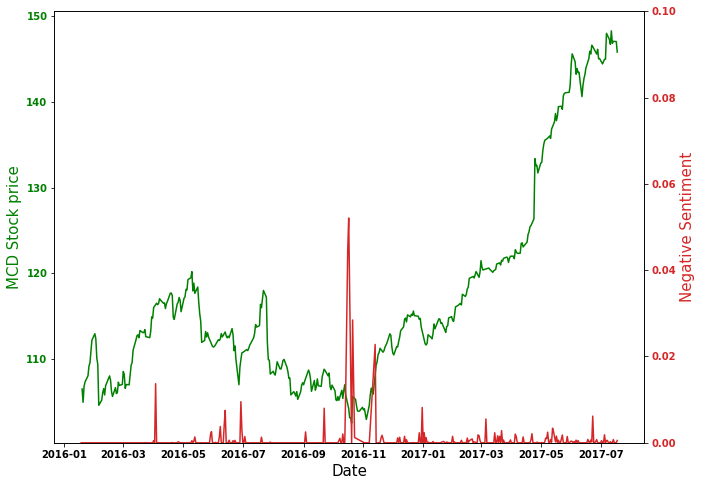

In [383]:
from matplotlib import pyplot as plt
fig, ax1 = plt.subplots(figsize=(10,7))
color = 'green'
ax1.set_xlabel('Date')
ax1.set_ylabel('MCD Stock price', color=color)
ax1.plot(returns,color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Negative Sentiment', color=color)  # we already handled the x-label with ax1
ax2.plot(date[:500],np.asarray(percentages[:500]),color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,0.1)
plt.rc('xtick', labelsize=5) 
plt.rc('ytick', labelsize=5)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig1 = plt.gcf()
plt.show()
fig1.savefig('Price_vs_Sentiment.png')
